In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex

%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

In [204]:
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints
from keras.regularizers import l2
from keras.layers import Dense, Embedding, Input, concatenate, Flatten, Layer
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout, Conv1D, MaxPool1D, BatchNormalization, TimeDistributed
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import SGD, Adam
from keras import backend as K

In [5]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [6]:
from gensim.models import Word2Vec

In [7]:
import os, re, pickle
import spacy
from spacy.tokens.doc import Doc

### Import Data

In [8]:
train = pd.read_csv('data/labeledTrainData.tsv', sep='\t')
print(train.shape)

(25000, 3)


In [9]:
test = pd.read_csv('data/testData.tsv', sep='\t')
print(test.shape)

(25000, 2)


### Pre-process Data

In [10]:
MAX_FEATURES = 25000
MAX_LEN = 350

In [11]:
list_sentences_train = train['review'].fillna("UNKNOWN").values.tolist()
list_sentences_test = test['review'].fillna("UNKNOWN").values.tolist()

In [12]:
tokenizer = text.Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(list_sentences_train)

In [13]:
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [14]:
X = sequence.pad_sequences(list_tokenized_train, maxlen=MAX_LEN)
X_test = sequence.pad_sequences(list_tokenized_test, maxlen=MAX_LEN)

In [15]:
y = train['sentiment'].values.reshape(-1,1)

In [270]:
y_softmax = np.array([np.array([0,1]) if x == 1 else np.array([1,0]) for x in y])

In [271]:
N_CLASSES = 2

In [272]:
X_train, X_val, y_train, y_val = train_test_split(X, y_softmax, test_size=0.1, random_state=42)

### Create Model - No External Knowledge

In [273]:
EMBED_SIZE = 8
CNN_FILTER_SIZE = 8
CNN_KERNEL_SIZE = 3

def create_model():
    input_sequence = Input(shape=(MAX_LEN, ))
    x = Embedding(input_dim=MAX_FEATURES, output_dim=EMBED_SIZE)(input_sequence)
    x = Dropout(0.5)(x)
    x = Conv1D(filters=CNN_FILTER_SIZE, kernel_size=CNN_KERNEL_SIZE, padding='same', kernel_regularizer=l2(0.0001))(x)
    #x = Bidirectional(LSTM(32,
    #                       return_sequences=True,
    #                       kernel_regularizer=l2(0.0001)))(x)
    #x = GlobalMaxPool1D()(x)
    #x = AttentionWithContext()(x)
    x = TimeDistributed(Dense(1, activation="elu", kernel_regularizer=l2(0.0001)))(x)
    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Dense(8, activation="elu", kernel_regularizer=l2(0.0001))(x)
    prediction = Dense(N_CLASSES, activation="softmax")(x)
    
    opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    #opt = SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)
    
    model = Model(inputs=input_sequence, outputs=prediction)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    return model

In [274]:
model = create_model()

BATCH_SIZE = 512
EPOCHS = 50

In [275]:
FILE_PATH = "models/keras_model_weights.hdf5"
checkpoint = ModelCheckpoint(FILE_PATH, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=15)
callbacks_list = [checkpoint, early]

In [276]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 350)               0         
_________________________________________________________________
embedding_21 (Embedding)     (None, 350, 8)            200000    
_________________________________________________________________
dropout_21 (Dropout)         (None, 350, 8)            0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 350, 8)            200       
_________________________________________________________________
time_distributed_7 (TimeDist (None, 350, 1)            9         
_________________________________________________________________
flatten_4 (Flatten)          (None, 350)               0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 350)               1400      
__________

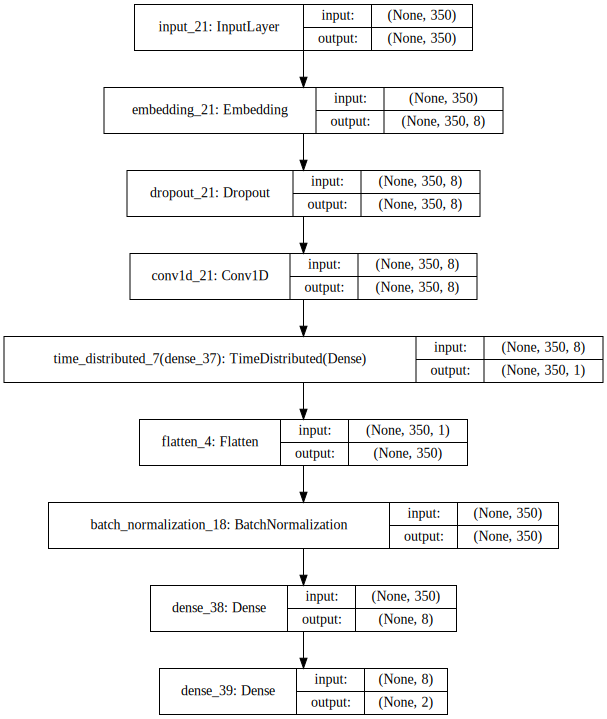

In [277]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [280]:
model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=[X_val, y_val], callbacks=callbacks_list)

Train on 22500 samples, validate on 2500 samples
Epoch 1/50
20992/22500 [==========================>...] - ETA: 0s - loss: 0.0518 - acc: 0.9828
Epoch 00001: val_loss did not improve
22500/22500 [==============================] - 1s 29us/step - loss: 0.0516 - acc: 0.9829 - val_loss: 0.3788 - val_acc: 0.8816
Epoch 2/50
20992/22500 [==========================>...] - ETA: 0s - loss: 0.0546 - acc: 0.9817
Epoch 00002: val_loss did not improve
22500/22500 [==============================] - 1s 29us/step - loss: 0.0545 - acc: 0.9815 - val_loss: 0.3701 - val_acc: 0.8872
Epoch 3/50
20992/22500 [==========================>...] - ETA: 0s - loss: 0.0505 - acc: 0.9835
Epoch 00003: val_loss did not improve
22500/22500 [==============================] - 1s 29us/step - loss: 0.0503 - acc: 0.9837 - val_loss: 0.3922 - val_acc: 0.8880
Epoch 4/50
20992/22500 [==========================>...] - ETA: 0s - loss: 0.0486 - acc: 0.9853
Epoch 00004: val_loss did not improve
22500/22500 [============================

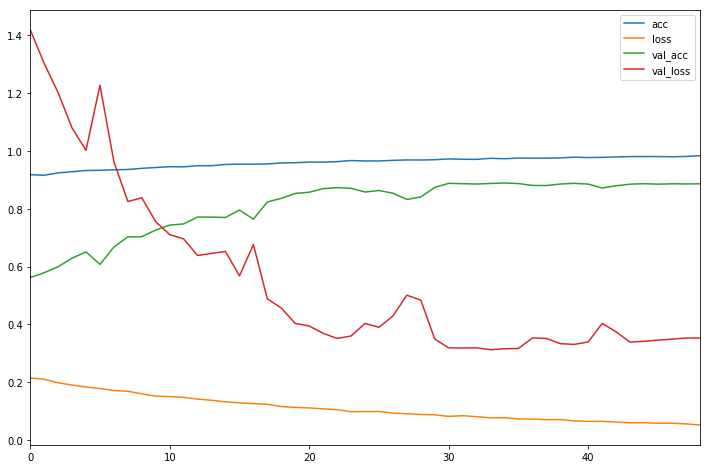

In [233]:
pd.DataFrame(model.history.history).plot(figsize=(12,8))

In [281]:
model = load_model(filepath=FILE_PATH, custom_objects={'AttentionWithContext': AttentionWithContext})

In [282]:
y_val_hat = model.predict(X_val)

In [283]:
print(accuracy_score(y_val, y_val_hat > 0.5))
print(roc_auc_score(y_val, y_val_hat))
print(confusion_matrix(y_val, y_val_hat > 0.5))
print(classification_report(y_val, y_val_hat > 0.5))

0.8848
0.955568316842


ValueError: multilabel-indicator is not supported

Useful tutorials:
* http://konukoii.com/blog/2018/02/19/twitter-sentiment-analysis-using-combined-lstm-cnn-models/

#### Extract Activations

In [78]:
from IPython.display import display, HTML

In [237]:
def create_get_activation_function(model, output_layer_int):
    inp = model.input
    output = model.layers[output_layer_int].output
    get_activations = K.function([inp]+ [K.learning_phase()], [output])
    return get_activations

In [284]:
act_model = load_model(filepath=FILE_PATH, custom_objects={'AttentionWithContext': AttentionWithContext})
get_activations = create_get_activation_function(act_model, 3)

In [285]:
word_to_hash = tokenizer.word_index
hash_to_word = {v:k for k,v in word_to_hash.items()}
hash_to_word[0] = ''

In [286]:
cmap = plt.cm.get_cmap('RdYlGn')

In [293]:
example = 4505

html_string = '<p>For training example: ' + str(example) + '</p>'

for node in range(CNN_FILTER_SIZE):
    activations = get_activations([[X_train[example]], 0.])[0]
    text = [hash_to_word[x] for x in X_train[example]]
    scaled_activations = activations[0,:,node] - activations[0,:,node].min()
    scaled_activations = scaled_activations / scaled_activations.max()
    scaled_activations = pd.rolling_mean(scaled_activations, CNN_KERNEL_SIZE, min_periods=1)
    new_string = ''
    for i, t in enumerate(text):
        new_string += '<span style="background-color: ' + str(rgb2hex(cmap(scaled_activations[i]))) + '">' + t + '</span>' + ' '

    html_string += '<p>CNN Filter: ' + str(node) + '</p><p>' + new_string + '</p>'
    
    
h = HTML(html_string)
display(h)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  # Remove the CWD from sys.path while we load stuff.


In [288]:
get_word_activations = create_get_activation_function(act_model, 5)

In [1]:
example = 4505

html_string = '<p>For training example: ' + str(example) + '</p>'


activations = get_word_activations([[X_train[example]], 0.])[0]
text = [hash_to_word[x] for x in X_train[example]]
scaled_activations = activations[0,:] - activations[0,:].min()
scaled_activations = scaled_activations / scaled_activations.max()

new_string = ''
for i, t in enumerate(text):
    new_string += '<span style="background-color: ' + str(rgb2hex(cmap(scaled_activations[i]))) + '">' + t + '</span>' + ' '

html_string += '<p>Time Distributed Dense Output: <p>' + new_string + '</p>'
    
    
h = HTML(html_string)
display(h)

NameError: name 'get_word_activations' is not defined

#### Word Embeddings

In [42]:
from scipy.spatial.distance import pdist, squareform

In [294]:
emb_layer = model.layers[1]
emb_layer_weights = emb_layer.get_weights()[0]
emb_layer_weights.shape

(25000, 8)

In [295]:
x_sq = squareform(pdist(emb_layer_weights[0:10000,:], metric='cosine'))

In [296]:
df_x_sq = pd.DataFrame(x_sq)

In [297]:
df_x_edge = df_x_sq.where(np.triu(np.ones(df_x_sq.shape)).astype(np.bool)).stack().reset_index()
df_x_edge.columns = ['source','target','weight']

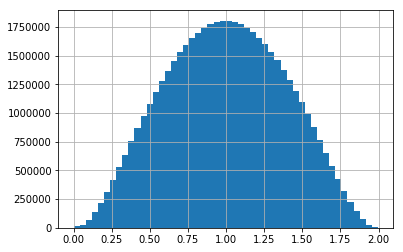

In [298]:
df_x_edge['weight'].hist(bins=50)

In [299]:
df_x_edge = df_x_edge[df_x_edge['weight'] < 0.1]
df_x_edge = df_x_edge[df_x_edge.source != df_x_edge.target]

In [300]:
df_x_edge.shape

(53910, 3)

In [301]:
df_x_edge['source_word'] = df_x_edge['source'].apply(lambda x: hash_to_word[x])
df_x_edge['target_word'] = df_x_edge['target'].apply(lambda x: hash_to_word[x])

In [302]:
df_x_edge.sort_values(by='weight')

,source,target,weight,source_word,target_word
49038726,8610,9081,0.003826,showcases,recurring
9100951,955,7441,0.006091,plenty,angelina
11323293,1204,8703,0.006345,post,borrows
15965200,1749,5575,0.006605,watchable,1960's
36846348,4870,7233,0.007237,photo,consequence
23181570,2676,3396,0.007839,significant,walls
45349098,6948,9924,0.007873,sunrise,bullying
21857364,2497,6117,0.008297,uninteresting,dim
49867394,9475,9944,0.008378,carlito's,projection
49690069,9206,9890,0.008671,martino,unremarkable


In [ ]:
df_x_edge.to_csv('../data/combine_activation_sim.csv', index=False)

In [ ]:
df_node_text = pd.DataFrame(df['text'], columns=['text'])
df_node_text['Id'] = df_node_text.index
df_node_text = df_node_text[['Id', 'text']]

In [545]:
from IPython.core.display import display, HTML
from string import Template
import json, random

In [547]:
random.seed(42)

n_nodes = 40
n_edges = 200

graph_data = { 'nodes': [], 'edges': [] }

for i in range(n_nodes):
    graph_data['nodes'].append({
            "id": "n" + str(i),
            "label": "n" + str(i),
            "x": random.uniform(0,1),
            "y": random.uniform(0,1),
            "size": random.uniform(0.2,1)
        })

for j in range(n_edges):
    x_center = random.uniform(0,1)
    y_center = random.uniform(0,1)
    x_dist = random.uniform(0.1,0.5)
    y_dist = random.uniform(0.2,0.5)
    neighborhood = []
    for node in graph_data['nodes']:
        if abs(node['x'] - x_center) < x_dist:
            if abs(node['y'] - y_center) < y_dist:
                neighborhood.append(int(node['id'].replace('n','')))
    if len(neighborhood) >= 2:
        ends = random.sample(neighborhood,2)
        graph_data['edges'].append({
                "id": "e" + str(j),
                "source": "n" + str(ends[0]),
                "target": "n" + str(ends[1])
            })

In [560]:
js_text_template = Template('''
    
    var g = $graph_data ;

s = new sigma({graph: g, container: '$container', settings: { defaultNodeColor: '#ec5148'} });

s.graph.nodes().forEach(function(n) {
  n.originalColor = n.color;
});
s.graph.edges().forEach(function(e) {
  e.originalColor = e.color;
});

s.bind('clickNode', function(e) {
  var nodeId = e.data.node.id,
      toKeep = s.graph.neighbors(nodeId);
  toKeep[nodeId] = e.data.node;

  s.graph.nodes().forEach(function(n) {
    if (toKeep[n.id])
      n.color = n.originalColor;
    else
      n.color = '#eee';
  });

  s.graph.edges().forEach(function(e) {
    if (toKeep[e.source] && toKeep[e.target])
      e.color = e.originalColor;
    else
      e.color = '#eee';
  });

  s.refresh();
});

s.bind('clickStage', function(e) {
  s.graph.nodes().forEach(function(n) {
    n.color = n.originalColor;
  });

  s.graph.edges().forEach(function(e) {
    e.color = e.originalColor;
  });

  s.refresh();
});


''')

In [561]:
js_text = js_text_template.substitute({'graph_data': json.dumps(graph_data),
                                       'container': 'graph-div'})

In [ ]:
'../ml-notebooks/js/sigma.min.js'

In [566]:
html_template = Template('''
<script src="../ml-notebooks/js/sigma.min.js"></script>

<div id="graph-div" style="height:800px"></div>
<script> $js_text </script>
''')

In [567]:
HTML(html_template.substitute({'js_text': js_text}))

### Create Model - Use Pretrained Embeddings, PoS Parsing

#### Prep Data

In [139]:
MAX_FEATURES = 25000
MAX_LEN = 350

In [99]:
list_sentences_train = train['review'].fillna("UNKNOWN").values.tolist()
list_sentences_test = test['review'].fillna("UNKNOWN").values.tolist()

In [100]:
list_sentences_train_parsed = [transform_doc(x, MAX_LEN=1000) for x in list_sentences_train]
list_sentences_test_parsed = [transform_doc(x, MAX_LEN=1000) for x in list_sentences_test]

In [102]:
with open('data/list_sentences_train_parsed.pkl', 'wb') as f:
    pickle.dump(list_sentences_train_parsed, f)
    
with open('data/list_sentences_test_parsed.pkl', 'wb') as f:
    pickle.dump(list_sentences_test_parsed, f)

In [140]:
tokenizer = text.Tokenizer(num_words=MAX_FEATURES, filters='!"#$%&()*+,-/:;<=>?@[\\]^`{}~\t\n', lower=False)
tokenizer.fit_on_texts(list_sentences_train_parsed)

In [141]:
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train_parsed)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test_parsed)

In [142]:
X_train = sequence.pad_sequences(list_tokenized_train, maxlen=MAX_LEN)
X_test = sequence.pad_sequences(list_tokenized_test, maxlen=MAX_LEN)

In [154]:
y = train['sentiment'].values.reshape(-1,1)

In [155]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

#### Inspect

In [143]:
list_sentences_train_parsed[0]

"With|ADP all_this_stuff|NOUN going|VERB down|PART at|ADP the_moment|NOUN with|ADP MJ|ENT i|PRON 've|VERB started|VERB listening|VERB to|ADP his_music|NOUN ,|PUNCT watching|VERB the_odd_documentary|NOUN here|ADV and|CCONJ there|ADV ,|PUNCT watched|VERB The_Wiz|PROPN and|CCONJ watched|VERB Moonwalker|ENT again|ADV .|PUNCT Maybe|ADV i|PRON just|ADV want|VERB to|PART get|VERB a_certain_insight|NOUN into|ADP this_guy|NOUN who|NOUN i|PRON thought|VERB was|VERB really|ADV cool|ADJ in|ADP the_eighties|DATE just|ADV to|PART maybe|ADV make|VERB up|PART my_mind|NOUN whether|ADP he|PRON is|VERB guilty|ADJ or|CCONJ innocent|ADJ .|PUNCT Moonwalker|ENT is|VERB part_biography|NOUN ,|PUNCT part_feature_film|NOUN which|ADJ i|PRON remember|VERB going|VERB to|PART see|VERB at|ADP the_cinema|NOUN when|ADV it|PRON was|VERB originally|ADV released|VERB .|PUNCT Some|DET of|ADP it|PRON has|VERB subtle_messages|NOUN about|ADP MJ's_feeling|NOUN towards|ADP the_press|NOUN and|CCONJ also|ADV the_obvious_message|N

In [144]:
list_tokenized_train[0]

[427,
 137,
 214,
 33,
 1728,
 13,
 10013,
 117,
 123,
 441,
 1956,
 12,
 9053,
 1,
 130,
 122,
 3,
 47,
 1,
 220,
 3,
 220,
 14945,
 151,
 2,
 550,
 117,
 44,
 147,
 6,
 73,
 72,
 1979,
 29,
 117,
 174,
 10,
 61,
 829,
 7,
 7258,
 44,
 6,
 353,
 87,
 59,
 1491,
 562,
 26,
 5,
 3109,
 38,
 2622,
 2,
 14945,
 5,
 1,
 52,
 117,
 302,
 137,
 6,
 58,
 33,
 1580,
 50,
 9,
 10,
 1306,
 460,
 2,
 699,
 4,
 9,
 36,
 53886,
 42,
 660,
 10795,
 3,
 88,
 4,
 1441,
 20,
 39,
 83,
 6477,
 1249,
 16,
 4,
 305,
 35,
 5,
 78,
 42,
 5265,
 279,
 729,
 19,
 1810,
 41,
 10013,
 7,
 783,
 96,
 19,
 20,
 137,
 6,
 610,
 35,
 3,
 134,
 9,
 418,
 2,
 699,
 164,
 579,
 10013,
 339,
 14,
 36321,
 12,
 3538,
 4,
 48,
 3169,
 10013,
 3,
 241,
 4,
 11248,
 45,
 113,
 18,
 26,
 85,
 9,
 14,
 4242,
 52,
 56,
 468,
 5,
 61,
 628,
 4,
 1528,
 455,
 11,
 390,
 8037,
 7622,
 199,
 257,
 50,
 9,
 377,
 391,
 5,
 106,
 22,
 14,
 7814,
 38,
 46,
 18037,
 3,
 15867,
 5,
 1046,
 15,
 2,
 402,
 26,
 357,
 10013,
 598,
 46,
 

In [145]:
index_word_dict = {v:k for k, v in tokenizer.word_index.items()}
word_index_dict = tokenizer.word_index

In [146]:
for w in list_tokenized_train[0]:
    print(index_word_dict[w])

With|ADP
going|VERB
down|PART
at|ADP
the_moment|NOUN
with|ADP
MJ|ENT
i|PRON
've|VERB
started|VERB
listening|VERB
to|ADP
his_music|NOUN
|PUNCT
watching|VERB
here|ADV
and|CCONJ
there|ADV
|PUNCT
watched|VERB
and|CCONJ
watched|VERB
Moonwalker|ENT
again|ADV
.|PUNCT
Maybe|ADV
i|PRON
just|ADV
want|VERB
to|PART
get|VERB
into|ADP
this_guy|NOUN
who|NOUN
i|PRON
thought|VERB
was|VERB
really|ADV
cool|ADJ
in|ADP
the_eighties|DATE
just|ADV
to|PART
maybe|ADV
make|VERB
up|PART
my_mind|NOUN
whether|ADP
he|PRON
is|VERB
guilty|ADJ
or|CCONJ
innocent|ADJ
.|PUNCT
Moonwalker|ENT
is|VERB
|PUNCT
which|ADJ
i|PRON
remember|VERB
going|VERB
to|PART
see|VERB
at|ADP
the_cinema|NOUN
when|ADV
it|PRON
was|VERB
originally|ADV
released|VERB
.|PUNCT
Some|DET
of|ADP
it|PRON
has|VERB
subtle_messages|NOUN
about|ADP
towards|ADP
the_press|NOUN
and|CCONJ
also|ADV
of|ADP
drugs|NOUN
are|VERB
br|NOUN
br|SYM
Visually|ADV
impressive|ADJ
but|CCONJ
of|ADP
course|NOUN
this|DET
is|VERB
all|DET
about|ADP
Michael_Jackson|ENT
so|ADP
unless|

#### Create Embedding Matrix
(or load one if you have it)

In [693]:
w2v_model = Word2Vec.load('models/w2v_model_32_plaintext')

In [694]:
EMBED_SIZE = w2v_model.vector_size
print('The size of the gensim word2vec vocab is: {}'.format(len(w2v_model.wv.vocab.items())))

unknown_word_count = 0
def choose_embedded_vector(word, unknown_word_count, verbose=False):
    if word in w2v_model.wv.vocab:
        return w2v_model.wv.word_vec(word), unknown_word_count
    else:
        if verbose:
            print('Unknown word: {}'.format(word))
        return np.random.rand(EMBED_SIZE), (unknown_word_count+1)

index_word_dict = {v:k for k, v in tokenizer.word_index.items()}
word_index_dict = tokenizer.word_index
num_words = tokenizer.num_words + 1 
print('The size of the keras token vocab is: {}'.format(len(index_word_dict)))
print('The tokenizer vocab is limited to: {}'.format(tokenizer.num_words))


embedding_weights = np.zeros((num_words, EMBED_SIZE))
for word, index in word_index_dict.items():
    if index < num_words:
        embedding_weights[index,:], unknown_word_count = choose_embedded_vector(word, unknown_word_count)

print('Total amount of words not found in gensim word2vec model: {}'.format(unknown_word_count))
print('Embedding matrix shape: {}'.format(embedding_weights.shape))

The size of the gensim word2vec vocab is: 69805
The size of the keras token vocab is: 88582
The tokenizer vocab is limited to: 25000
Total amount of words not found in gensim word2vec model: 361
Embedding matrix shape: (25001, 32)


In [698]:
EMBED_SIZE

32

#### Train Model

In [699]:
CNN_FILTER_SIZE = 32
CNN_KERNEL_SIZE = 3

def create_model():
    input_sequence = Input(shape=(MAX_LEN, ))
    x = Embedding(input_dim=num_words, output_dim=EMBED_SIZE, input_length=MAX_LEN, mask_zero=False, weights=[embedding_weights], trainable=True)(input_sequence)
    x = Dropout(0.5)(x)
    x = Conv1D(filters=CNN_FILTER_SIZE, kernel_size=CNN_KERNEL_SIZE, padding='same', kernel_regularizer=l2(0.0001))(x)
    #x = Bidirectional(LSTM(32,
    #                       return_sequences=True,
    #                       kernel_regularizer=l2(0.0001)))(x)
    #x = GlobalMaxPool1D()(x)
    x = AttentionWithContext()(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation="elu", kernel_regularizer=l2(0.0001))(x)
    prediction = Dense(N_CLASSES, activation="sigmoid")(x)
    
    opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    #opt = SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)
    
    model = Model(inputs=input_sequence, outputs=prediction)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

    return model

In [700]:
model = create_model()

BATCH_SIZE = 512
EPOCHS = 50

In [701]:
FILE_PATH = "models/keras_model_weights.hdf5"
checkpoint = ModelCheckpoint(FILE_PATH, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_loss", mode="min", patience=15)
callbacks_list = [checkpoint, early]

In [702]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        (None, 350)               0         
_________________________________________________________________
embedding_31 (Embedding)     (None, 350, 32)           800032    
_________________________________________________________________
dropout_30 (Dropout)         (None, 350, 32)           0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 350, 32)           3104      
_________________________________________________________________
attention_with_context_20 (A (None, 32)                1088      
_________________________________________________________________
batch_normalization_30 (Batc (None, 32)                128       
_________________________________________________________________
dense_59 (Dense)             (None, 32)                1056      
__________

In [727]:
model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=[X_val, y_val], callbacks=callbacks_list)

Train on 22500 samples, validate on 2500 samples
Epoch 1/50
22016/22500 [============================>.] - ETA: 0s - loss: 0.3717 - acc: 0.8375
Epoch 00001: val_loss improved from 0.31113 to 0.30841, saving model to models/keras_model_weights.hdf5
22500/22500 [==============================] - 1s 39us/step - loss: 0.3726 - acc: 0.8373 - val_loss: 0.3084 - val_acc: 0.8720
Epoch 2/50
20992/22500 [==========================>...] - ETA: 0s - loss: 0.3788 - acc: 0.8348
Epoch 00002: val_loss did not improve
22500/22500 [==============================] - 1s 36us/step - loss: 0.3776 - acc: 0.8357 - val_loss: 0.3098 - val_acc: 0.8724
Epoch 3/50
20992/22500 [==========================>...] - ETA: 0s - loss: 0.3726 - acc: 0.8376
Epoch 00003: val_loss did not improve
22500/22500 [==============================] - 1s 35us/step - loss: 0.3722 - acc: 0.8380 - val_loss: 0.3090 - val_acc: 0.8728
Epoch 4/50
22016/22500 [============================>.] - ETA: 0s - loss: 0.3681 - acc: 0.8413
Epoch 00004: 

Epoch 30/50
20992/22500 [==========================>...] - ETA: 0s - loss: 0.3567 - acc: 0.8459
Epoch 00030: val_loss did not improve
22500/22500 [==============================] - 1s 35us/step - loss: 0.3567 - acc: 0.8457 - val_loss: 0.3040 - val_acc: 0.8748
Epoch 31/50
22016/22500 [============================>.] - ETA: 0s - loss: 0.3615 - acc: 0.8436
Epoch 00031: val_loss did not improve
22500/22500 [==============================] - 1s 37us/step - loss: 0.3613 - acc: 0.8433 - val_loss: 0.3028 - val_acc: 0.8752
Epoch 32/50
22016/22500 [============================>.] - ETA: 0s - loss: 0.3614 - acc: 0.8454
Epoch 00032: val_loss did not improve
22500/22500 [==============================] - 1s 35us/step - loss: 0.3611 - acc: 0.8456 - val_loss: 0.3038 - val_acc: 0.8736
Epoch 33/50
22016/22500 [============================>.] - ETA: 0s - loss: 0.3597 - acc: 0.8453
Epoch 00033: val_loss did not improve
22500/22500 [==============================] - 1s 36us/step - loss: 0.3600 - acc: 0.84

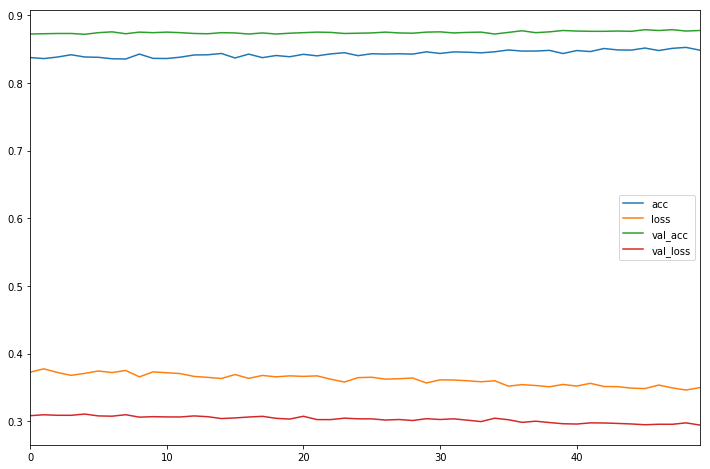

In [728]:
pd.DataFrame(model.history.history).plot(figsize=(12,8))

In [705]:
model = load_model(filepath=FILE_PATH, custom_objects={'AttentionWithContext':AttentionWithContext})

In [729]:
y_hat = model.predict(X_val)

In [730]:
print(accuracy_score(y_val, y_hat > 0.5))
print(roc_auc_score(y_val, y_hat))
print(confusion_matrix(y_val, y_hat > 0.5))
print(classification_report(y_val, y_hat > 0.5))

0.8772
0.951000501915
[[1038  190]
 [ 117 1155]]
             precision    recall  f1-score   support

          0       0.90      0.85      0.87      1228
          1       0.86      0.91      0.88      1272

avg / total       0.88      0.88      0.88      2500



### Helper Functions

A lot of the spacy code was pulled from examples: https://github.com/explosion

In [19]:
nlp = spacy.load('en_core_web_sm')

LABELS = {
    'ENT': 'ENT',
    'PERSON': 'ENT',
    'NORP': 'ENT',
    'FAC': 'ENT',
    'ORG': 'ENT',
    'GPE': 'ENT',
    'LOC': 'ENT',
    'LAW': 'ENT',
    'PRODUCT': 'ENT',
    'EVENT': 'ENT',
    'WORK_OF_ART': 'ENT',
    'LANGUAGE': 'ENT',
    'DATE': 'DATE',
    'TIME': 'TIME',
    'PERCENT': 'PERCENT',
    'MONEY': 'MONEY',
    'QUANTITY': 'QUANTITY',
    'ORDINAL': 'ORDINAL',
    'CARDINAL': 'CARDINAL'
}


pre_format_re = re.compile(r'^[\`\*\~]')
post_format_re = re.compile(r'[\`\*\~]$')
url_re = re.compile(r'\[([^]]+)\]\(%%URL\)')
link_re = re.compile(r'\[([^]]+)\]\(https?://[^\)]+\)')


def strip_meta(text):
    if type(text) == str:
        text = link_re.sub(r'\1', text)
        text = text.replace('&gt;', '>').replace('&lt;', '<')
        text = pre_format_re.sub('', text)
        text = post_format_re.sub('', text)
        return text
    else:
        return ''
    

def represent_word(word):
    if word.like_url:
        return '%%URL|X'
    text = re.sub(r'\s', '_', word.text)
    tag = LABELS.get(word.ent_type_, word.pos_)
    if not tag:
        tag = '?'
    return text + '|' + tag


def merge_clean_sentence(nlp, text, collapse_punctuation=True, collapse_phrases=True):
    doc = nlp(text)
    if collapse_punctuation:
        spans = []
        for word in doc[:-1]:
            if word.is_punct:
                continue
            if not word.nbor(1).is_punct:
                continue
            start = word.i
            end = word.i + 1
            while end < len(doc) and doc[end].is_punct:
                end += 1
            span = doc[start : end]
            spans.append(
                (span.start_char, span.end_char,
                 {'tag': word.tag_, 'lemma': word.lemma_, 'ent_type': word.ent_type_})
            )
        for start, end, attrs in spans:
            doc.merge(start, end, **attrs)

    if collapse_phrases:
        for np in list(doc.noun_chunks):
            np.merge(tag=np.root.tag_, lemma=np.root.lemma_, ent_type=np.root.ent_type_)
    
    return doc


def transform_doc(text, MAX_LEN):
    d = merge_clean_sentence(nlp, text, collapse_punctuation=False, collapse_phrases=True)
    strings = []
    for sent in d.sents:
        if sent.text.strip():
            for w in sent:
                if not w.is_space:
                    strings.append(represent_word(w))
    if strings:
        return ' '.join(strings[0:MAX_LEN])
    else:
        return ' '.join(['' for x in range(MAX_LEN)])

Attention adapted from: https://gist.github.com/cbaziotis/6428df359af27d58078ca5ed9792bd6d

In [20]:
def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)
    

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.

    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.

    Note: The layer has been tested with Keras 2.0.6

    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]